# Further Steps Towards a Standard Testbed for Optical Music Recognition

This Notebook serves as a replication guide for the experiments with OMR evaluation described in the publication "Further Steps Towards a Standard Testbed for Optical Music Recognition" by Hajič jr., Novotný, Pecina and Pokorný, ISMIR 2016.

The following scenarios will be shown:

* Measuring inter-annotator agreement (Replicating Fig. 1 in the article) on human judgment data
* Evaluating an automated OMR evaluation metric against the human judgment data



## Requirements

To successfully replicate our results, you will need:

* bash+git (to clone this repository)
* Python 2.7.11 + scientific stack (numpy, scipy, matplotlib -- we recommend using Anaconda)

We recommend using Anaconda and setting up a separate virtual environment with the ``conda`` tool, so that replicating our setup does not interfere with your own work.

Further Python packages you will need to use our implementations of the proposed automated OMR evaluation metrics:

* Levenshtein (implements Levenshtein distance)
* zss (implements tree edit distance)

To run the **Ly** evaluation metric script, you will need to install:

* LilyPond (an open-source music typesetting software based on LaTeX/Scheme)

Other software we used, but you will not need in this tutorial:

* MuseScore 2.0.2 (an open-source music notation editor)


### Our code

The evaluation code is in package `omreval`, in `evaluations/code/`. To install, we recommend using `pip wheel` and `pip install`.

## Measuring inter-annotator agreement on human judgment data

In this section, we will compute inter-annotator agreement metrics ($L$, $L_w$ and $\hat{L}_w$ in the paper), reconstructing Figure 1 from the paper. We will gradually refine the computation to get a better idea of the extent to which we can trust the annotated test case corpus to give us useful and reliable estimates of the relative cost-to-correct for the test cases.

### Why not kappa?

The most frequent measure for inter-annotator agreement is Cohen's kappa and similar metrics (Fleisch's kappa, Krippendorf's alpha). However, these require estimating the probability of chance agreement, which in turn requires
placing a prior on the probability that a given pair of "system outputs" is equally bad, for all intents and purposes. We have nothing to base this estimate on: for most of the pairs, we have little prior idea about whether they are easy or difficult to rank. 

(We have an idea for some of them, especially the longer ones that differ merely by the amount of mangling done; they are in the corpus mainly to ensure that any metric that behaves sensibly on small-scale examples will also behave sensibly on larger scales. However, this is still just 15 of the overall 82 non-control test cases, so the maximum entropy prior estimate for certain vs uncertain Bernoulli distribution is still ((82 - 15) / 82) * 0.5, which is about 0.4... But at this point, we still need some probabilistic model of the annotation. We will come back to this later.)

## Preparing the annotation data

Throughout the rest of the Notebook, we will assume you `cd` to the `supplementary/evaluations` directory.
Just change the following line accordingly.

In [2]:
cd ~/mhr/publications/ismir2016/supplementary/evaluations

/Users/hajicj/mhr/publications/ismir2016/supplementary/evaluations


In [3]:
import omreval.process_annotations as pa
annots = pa.read_annotations('annotations/annotations.csv')

import numpy
import scipy.stats
import matplotlib.pyplot as plt

# Use this for plots to appear inside the Jupyter Notebook.
%matplotlib inline

First, we will need to filter out annotations that cannot be used: control cases and the work of annotators who did not complete the full set.

We will first filter out annotators who did not do 99 or 100 items (there was a bug in the server code which dropped the last annotation for 3 annotators).

In [4]:
annots_per_user = pa.collect_per_annotator(annots)
full_annots = pa.reconstruct_from_per_annotator(annots_per_user,
                                                names=[n for n in annots_per_user
                                                       if pa.get_n_rankings(annots_per_user[n]) > 98],
                                                exclude=False)

full_per_user = pa.collect_per_annotator(full_annots)
for n in sorted(full_per_user.keys()):
    print '{0}:\t{1}'.format(n, pa.get_n_rankings(annots_per_user[n]))

A01.1:	100
A02.1:	100
A03.1:	100
A03.2:	100
A04.1:	100
A05.1:	100
A06.2:	100
A07.1:	99
A08.1:	100
A09.1:	100
A10.1:	100
A11.1:	100
A11.2:	99
A12.1:	99
A13.1:	100


Next, we need to filter out the control group.

In [5]:
ctrl_annots = pa.extract_control_group(full_annots, exclude=False)
noctrl_annots = pa.extract_control_group(full_annots, exclude=True)

Now, we have narrowed down the full annotation data to the subset usable for reporting agreement.

## Overall agreement levels

First, we can look at the distribution of inter-annotator agreement on the test cases.

We represent votes for the first of a pair of system outputs in an example as `-1.0`, and votes for the second system output as `1.0`. Then, if we compute the average vote for an item, its absolute value will correlate with the strength of annotator consensus. If we plot the histogram of these averages, we will see how certain overall the annotators were.

If the level of certainty turns out very low (mostly close to 0), it's a bad thing: there is no clear difference in the cost-to-correct of the test cases. If the average level of certainty is close to 1, on the other hand, it means our examples were mostly trivial: there were few cases where it's genuinely hard to say which "mangling" was worse. This could imply that judging the relative cost-to-correct of various notation errors is trivial and there is a clear way of assigning this cost, or -- worse -- it would mean that we selected only trivial examples that do not really touch the interesting "gray zone".

Let's collect the item-wise average ranks and their absolute values, which can be used as a simple measure of certainty.


In [6]:
iwa = pa.item_wise_averages(noctrl_annots)

**Technical note:** Because of the 3 annotators whose last response was not recorded,
there are some erratic consensus strengths outside the 8 possible consensus strengths
of 15 votes (0 vs 15, 1 vs 14, ..., 7 vs 8), as some items have only 14 (or 13, or 12)
responses. Just for plotting purposes, we'll find them and leave them out.

In [7]:
examples = pa.flatten_annots_to_examples(noctrl_annots)  # Flattens the data structure.
not_full_examples = {e: r for e, r in examples.iteritems() if len(r) < 15}

iwa_examples = pa.flatten_annots_to_examples(iwa)
iwa_full_examples = {e: i for e, i in iwa_examples.iteritems() if e not in not_full_examples}

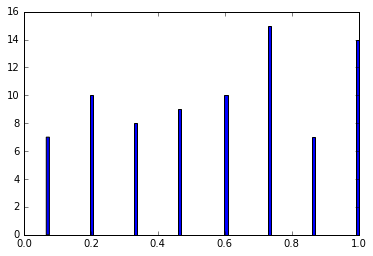

In [8]:
iwa_abs_values = numpy.abs(numpy.array(iwa_full_examples.values()))
_, _, _ = plt.hist(iwa_abs_values, 100) # Just use a lot of bins, we'll see the relevant information anyway.
plt.show()

We see that the distribution of annotator consensus strength is roughly uniform, with a slight increase at the more certain tail. This is perhaps slightly less overall agreement than we would ideally like, but it is nevertheless not disastrous.

Let's explore further: what are the agreement patterns? Is disagreement caused mostly by a few annotators, or is it scattered throughout more or less randomly?

We will turn to measuring pairwise agreement. However, because we will have to start using some formulae, let's first define some notation.

## Notation

The test case corpus $C$ is composed of individual test cases $c_1 \dots c_N \in C$. The number of test cases is $N$.
Each test case $c_i$ is composed of an *ideal* score $I_i$ and two "mangled" system outputs, $P_i^{(1)}$ and $P_i^{(2)}$. Formally: $c_i = \left< I_i, P_i^{(1)}, P_i^{(2)} \right>$

We have a set $\mathcal{A}$ of $K$ annotators $a_1 \dots a_K$. We asked them for each $c_i \in C$ to choose which of the $P_i^{(1)}, P_i^{(2)}$ is less mangled, given that the correct recognition would have been $I_i$. This is formalized for an annotator $a$ as assigning $r_a(c_i) = -1$ if they preferred $P_i^{(1)}$ and $r_a(c_i) = 1$ if they preferred $P_i^{(2)}$. The letter $r$ stands for "rank". The average rank given by a subset $\mathcal{G}$ of annotators to example $c$ is denoted as $r_{\mathcal{G}}(c)$, with $r_{\mathcal{A}}(c)$ is being the average over all annotators.

To recap:

* $c_1, \dots, c_N \in C$ are the test cases in the corpus,
* Each test case $c_i = \left< I_i, P_i^{(1)}, P_i^{(2)} \right>$,
* The annotators $a_1 \dots a_K$ assign a $-1$ or $+1$ to each $c_i$, and denote this assignment $r_a(c_i)$. 
  The average rank over a subset $\mathcal{G}$ of annotators is denoted $r_{\mathcal{G}}(c_i)$.


## Obtaining the agreement matrix

One elementary thing we can do is compute the agreement matrix: for each pair of annotators, measure the proportion of test cases where they agree with each other. To get this number for a single pair of annotators, we can use the `pa.pairwise_agreement()` function.

This will help us assess whether we can trust our annotators, and to what extent can we trust each one.
In turn, we will know how much confidence we can have in our data.
If we find out that most disagreement is confined to several low-quality annotators, we can have much greater
confidence in our findings once we filter them out, for instance. (Not that not enough effort is the only cause of such extensive disagreements an annotator could have with the others!)

The formula for the agreement score of annotators `a` and `b` is then:

$$
L(a, b) = \frac{1}{N} \sum_{c \in C} \frac{\lvert r_a(c) + r_b(c) \rvert}{2}
$$ 

which is simply the proportion of test cases the given annotators agree on: each term in the sum is either 1 if both annotators agree, or 0 if they don't.

In [9]:
names = sorted(pa.collect_per_annotator(noctrl_annots).keys())
K = len(names)

agreement_matrix = numpy.zeros((K, K))
for i, n in enumerate(names):
    for j, m in enumerate(names):
        a = pa.pairwise_agreement(n, m, noctrl_annots)
        agreement_matrix[i, j] = a

Since we will be plotting more agreement matrices, let's define a shortcut:

In [10]:
def show_agreement_matrix(m, names=None):
    plt.imshow(m, interpolation='nearest')

    if names is not None:
        # Let's label the axes by annotator...
        ax = plt.gca()
        ax.set_yticks(range(K))
        ax.set_yticklabels(names)

    plt.colorbar()
    plt.show()

And visualize the trivial case:

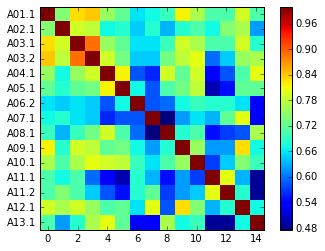

In [11]:
show_agreement_matrix(agreement_matrix, names=names)

The diagonal is 1.0 and we can clearly see that the two annotators who went through the data twice (A03 and A11) do agree with themselves more than with other people.

### Weighed agreement

However, this way of counting agreement doesn't take into account that some disagreement is genuine.
That is: if annotator A doesn't agree with B on an item where annotators C - Z *do* agree, then it is
probably not a genuinely difficult . On the other hand, if A and B don't agree on an item 
where C - Z are split roughly 50:50, it's probable that the system outputs are more or less just as bad,
and that annotators are picking one over the other rather randomly.

What if we tried weighing the individual examples by how strongly the other annotators agree?

Let's define *weighed* agreement:

$$
L_w(a, b) = \frac{1}{N} \sum_{c \in C} w^{(-a,b)}(c) \frac{\lvert r_a(c) + r_b(c) \rvert}{2}
$$

where the weights $w_i^{(-a,b)}$ is the strength of the consensus of the other annotators $a \in A \setminus a, b$:

$$
w^{(-a,b)}(c) = \frac{1}{K - 2} \lvert \sum_{a' \in A \setminus a, b} r_{a'}(c) \rvert
$$

This way, disagreements in the sum in $L_w$ where consensus is weak count less than where the consensus is weak.

When computing the weights, notice that we do not include the votes of $a$ and $b$ in the consensus. (In case consensus is strong, we also do not care in $L_w$ if the annotators agree with it or not. This is a weakness we will remedy later.)

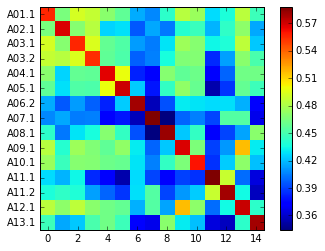

In [12]:
weighed_agreement_matrix = numpy.zeros((K, K))
for i, n in enumerate(names):
    for j, m in enumerate(names):
        a = pa.pairwise_agreement(n, m, noctrl_annots, weighed=True)
        weighed_agreement_matrix[i, j] = a

show_agreement_matrix(weighed_agreement_matrix, names=names)

Three significant things happened:

* The range of agreement values has shrunk considerably.
* The values on the diagonal started to differ.
* We are starting to see some annotator groups more clearly (annotators A01 - A05, A09, A10, A12 vs. the rest, which 
  doesn't agree too much with anyone)
  
Regarding 1, this is quite expected: since $w_i^{(a,b)} \leq 1$, it follows that $L_w(a,b) \leq L(a,b)$. However, no. 2 is a bit more problematic. While $L(a, b) \leq 1$, because the weight computation excludes $a$ and $b$, the self-agreement is weighed differently for each $a, b$ pair of annotators. We should complement the weighed agreement by a version that is normalized to have a maximum of 1.

### Normalized weighed agreement

Looking at the formula for $L_w$, we can re-normalize quite easily. In $L$, the term $\frac{1}{N}$ is the inverse of the sum of maximum contributions of the individual items. We can swap $N$ for $\sum_{c \in C} w^{(-a,b)}(c)$. (This is the same as computing $L_w(a, a)$, so we don't have to implement anything new.)

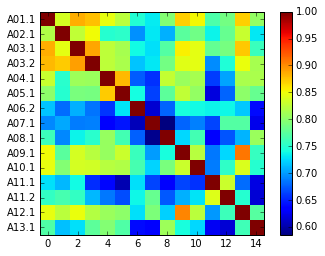

In [13]:
weighed_normalized_agreement_matrix = numpy.zeros((K, K))
for i, n in enumerate(names):
    self_agreement = pa.pairwise_agreement(n, n, noctrl_annots, weighed=True)
    for j, m in enumerate(names):
        a = pa.pairwise_agreement(n, m, noctrl_annots, weighed=True)
        weighed_normalized_agreement_matrix[i, j] = a / self_agreement

show_agreement_matrix(weighed_normalized_agreement_matrix, names=names)

**And so we get close to Fig. 1 in the article.**

The agreement patterns have now become quite prominent. (At least we think so.) 

The interpretation of the numbers is: if we take the level of certainty achieved by the other annotators as the *maximum achievable certainty* on the given data, this the proportion of "expected" agreement that the annotators $a, b$ have achieved.

The difference between this figure and Fig. 1 in the article is that in the article, we also estimated the random baseline $\hat{L}_w$ by generating 10 "random annotators". We then used the average agreement among the random annotators as the lower end of the scale, which came out to some 0.55, so the colors in the article are slightly less blue.

## How to assess an evaluation metric?

If you have your own metric, follow the instructions in `evaluations/README.md` to create a costs file.
We will be using the cost files here from our own metrics in `evaluations/costs`.

In [14]:
costs = pa.read_costs('./costs/costs_treedist-zss-Levenshtein.csv')

We have costs $\mathcal{L}$ for individual system outputs, but we have annotations for *pairs* of system outputs. To measure correlation of the cost function with the annotations, we need to convert the cost into the differences format. The annotations give us a number between $-1$ and $1$, where $-1$ is unanimous preference for the first of the pair and $1$ is preference for the second. To mirror this setup, for a test case $c_i = \left< I_i, P_i^{(1)}, P_i^{(2)} \right>$, we compute:

$$\mathcal{L}_{diff}(c_i) = \mathcal{L}(P_i^{(1)}) - \mathcal{L}(P_i^{(2)})$$

This is negative when the cost of the first example is *lower* than the second, reflecting a preference for the first.
We can then compute the correlation between $\mathcal{L}_{diff}$ and $r_{\mathcal{A}}$ over the corpus $C$. This process is implemented in the `costs2metrics()` function in the `process_annotation`  module.

In [15]:
spearman, pearson, kendall = pa.costs2metrics(costs, iwa)  
# Note that the control cases have already been filtered from iwa, so they do not get included in the computation.
print 'Spearman: {0:.2f}\nPearson: {1:.2f}\nKendall: {2:.2f}'.format(spearman, pearson, kendall)

Spearman: 0.57
Pearson: 0.40
Kendall: 0.43


However, because we are measuring these numbers against the imperfect annotations, we do not know
how to interpret these numbers: how good are they? They are not very good in absolute terms, but as the ideal cannot be 1.0, because the annotators themselves have disagreements about relative cost, what can we reasonably expect to achieve? 

We could measure, for instance, what the correlation coefficients would turn out to be if our cost function was another group of human annotators. This should give us the upper limit achievable with the given annotations, with the cost difference $\mathcal{L}^*_{diff} = r_{\mathcal{A}}$.

To estimate how much new annotators would agree with the old ones, we randomly split our annotators into two evenly sized groups and measure correlations between these two groups. We repeat the split 1000 times to get a number we can be more confident in.

In [16]:
N_GROUPS_SAMPLED = 1000  # Reasonable minimum
GROUP_SIZE = K / 2

import itertools
import random

all_groups = map(tuple, map(sorted, list(itertools.combinations(names, K / 2))))
random.shuffle(all_groups)
sample_groups = all_groups[:N_GROUPS_SAMPLED]

For each split, we will measure the correlation between the consensus of the annotator groups.

In [17]:
spearman_per_group = {}
pearson_per_group = {}
kendall_per_group = {}

for g in sample_groups:
    # Get the item-wise averages for the group and the complement.
    # (There's a function for filtering the data by annotator.)
    g_iwa = pa.item_wise_averages(pa.filter_annotators(noctrl_annots, names=g, exclude=False))
    g_prime_iwa = pa.item_wise_averages(pa.filter_annotators(noctrl_annots, names=g, exclude=True))
    
    # We can use the item-wise averages as the "cost difference" of some ideally scaled
    # cost function. This just aligns the IWAs of the annotators in g and its complement
    # into two numpy vectors, so that they can be directly fed into a correlation metric
    # from scipy.
    g_i, g_prime_i = pa.cost_diffs_vs_iwas(g_iwa, g_prime_iwa)
    
    # The correlation metrics give NaNs for samples with zero variance, so we
    # need to introduce some epsilon.
    if g_i.max() - g_i.min() == 0:
        g_i_argmax = numpy.argmax(g_prime_i)
        g_i[g_prime_argmax] += 0.00001
    if g_prime_i.max() - g_prime_i.min() == 0:
        g_argmax = numpy.argmax(g_i)
        g_prime_i[g_argmax] += 0.00001
    
    # Now compute the correlation coefficients
    spearman_per_group[g] = scipy.stats.spearmanr(g_i, g_prime_i).correlation
    pearson_per_group[g] = scipy.stats.pearsonr(g_i, g_prime_i)[0]
    kendall_per_group[g] = scipy.stats.kendalltau(g_i, g_prime_i).correlation

# And finally average the values and get standard deviations
s_values = numpy.array(spearman_per_group.values())
spearman_average = numpy.average(s_values[numpy.isfinite(s_values)])
spearman_stddev = numpy.std(s_values[numpy.isfinite(s_values)])

p_values = numpy.array(pearson_per_group.values())
pearson_average = numpy.average(p_values[numpy.isfinite(p_values)])
pearson_stddev = numpy.std(p_values[numpy.isfinite(p_values)])

k_values = numpy.array(kendall_per_group.values())
kendall_average = numpy.average(k_values[numpy.isfinite(k_values)])
kendall_stddev = numpy.std(k_values[numpy.isfinite(k_values)])

print('Spearman:\t{0:.2f}\tdev: {1:.2f}\nPearson:\t{2:.2f}\tdev: {3:.2f}\nKendall:\t{4:.2f}\tdev: {5:.2f}'
      ''.format(spearman_average, spearman_stddev, pearson_average, pearson_stddev, kendall_average, kendall_stddev))

Spearman:	0.81	dev: 0.04
Pearson:	0.81	dev: 0.04
Kendall:	0.69	dev: 0.04


To get the correlation metrics relative to these expected upper bounds:

In [18]:
spearman_rel_avg = spearman / spearman_average
pearson_rel_avg = pearson / pearson_average
kendall_rel_avg = kendall / kendall_average

print 'Spearman: {0:.2f}\nPearson: {1:.2f}\nKendall: {2:.2f}'.format(spearman_rel_avg, pearson_rel_avg, kendall_rel_avg)

Spearman: 0.70
Pearson: 0.49
Kendall: 0.63


It is apparent that there is still some way to go. It is worth seeing that the cost performs much worse in the Pearson coefficient than in the others. This might be because Pearson measures linear correlation, while the other coefficients only measure monotonicity. Recall that the way we estimated the achievable correlations, the cost differences $\mathcal{L}^*_{diff}$ were ideally scaled: they both fell into the $\left< -1, 1 \right>$ range.

## Extending the annotations

If you wish to annotate our test case corpus, feel free to do so!
The annotation server is available at 

http://quest.ms.mff.cuni.cz:6480/omreval/

If you have your own examples and wish to have them annotated using our server,
or if you want to run your own `omreval` server instance, get in touch at

`hajicj@ufal.mff.cuni.cz`